In [28]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import imageio.v2 as imageio

In [29]:
path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path + i for i in image_list_orig]
mask_list = [mask_path + i for i in image_list_orig]

Text(0.5, 1.0, 'Segmentation')

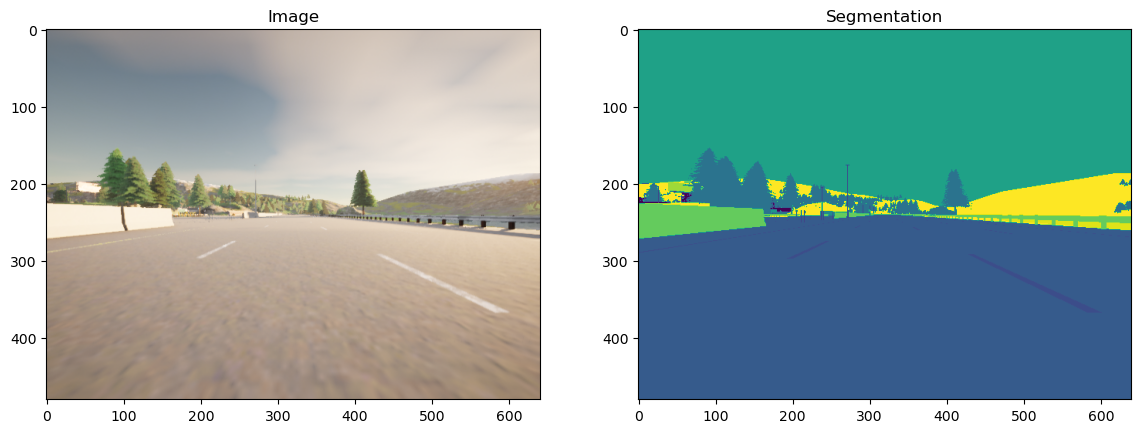

In [30]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [31]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000028.png'>)


In [32]:
image_filenames = tf.constant(image_list)
mask_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames))

for image, mask in dataset.take(1):
    print(image, mask)

tf.Tensor(b'./data/CameraRGB/000026.png', shape=(), dtype=string) tf.Tensor(b'./data/CameraMask/000026.png', shape=(), dtype=string)


In [33]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    
    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [34]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(filters=n_filters,
                kernel_size=3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters=n_filters,
                kernel_size=3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv
    
    skip_connection = conv

    return next_layer, skip_connection

In [35]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(filters=n_filters,
                        kernel_size=3,
                        strides=2,
                        padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(filters=n_filters,   # Number of filters
                 kernel_size=3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(filters=n_filters,  # Number of filters
                 kernel_size=3,   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)
    return conv

In [36]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16, dropout_prob=0.3, max_pooling=False)
    
    ublock6 = upsampling_block(expansive_input=cblock5[0], contractive_input=cblock4[1], n_filters=n_filters*8)
    ublock7 = upsampling_block(expansive_input=ublock6, contractive_input=cblock3[1], n_filters=n_filters*4)
    ublock8 = upsampling_block(expansive_input=ublock7, contractive_input=cblock2[1], n_filters=n_filters*2)
    ublock9 = upsampling_block(expansive_input=ublock8, contractive_input=cblock1[1], n_filters=n_filters*1)
    
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(filters=n_classes, kernel_size=1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [37]:


img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [38]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 96, 128, 32)          896       ['input_2[0][0]']             
                                                                                                  
 conv2d_21 (Conv2D)          (None, 96, 128, 32)          9248      ['conv2d_20[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 48, 64, 32)           0         ['conv2d_21[0][0]']           
 g2D)                                                                                       

 conv2d_39 (Conv2D)          (None, 96, 128, 23)          759       ['conv2d_38[0][0]']           
                                                                                                  
Total params: 8640471 (32.96 MB)
Trainable params: 8640471 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [44]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


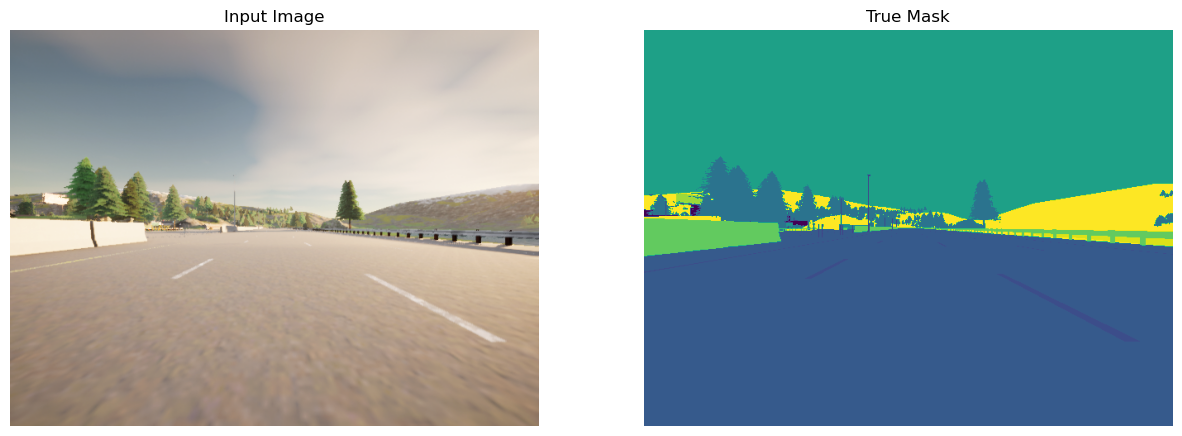

In [46]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


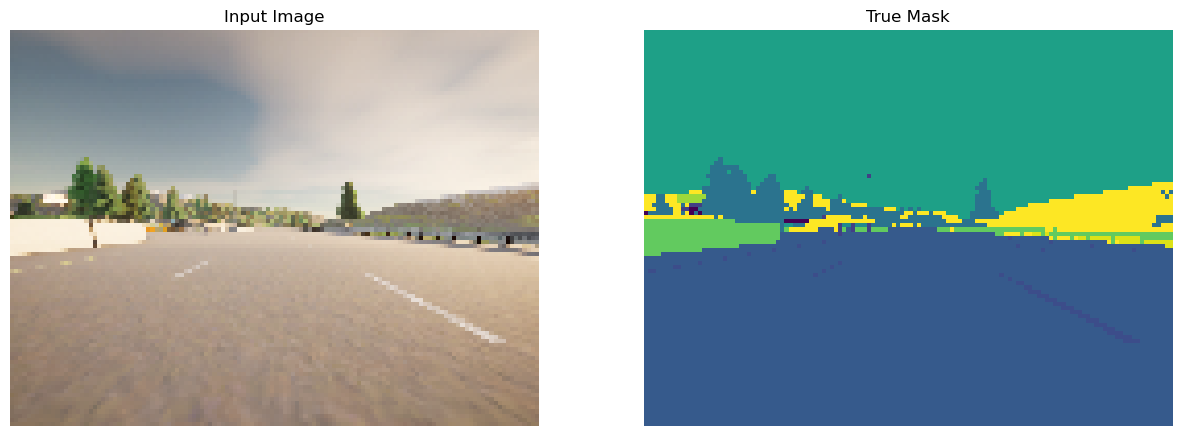

In [47]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [48]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/10
34/34 [==============================] - 116s 3s/step - loss: 1.9355 - accuracy: 0.4524
Epoch 2/10
34/34 [==============================] - 116s 3s/step - loss: 0.8791 - accuracy: 0.7613
Epoch 3/10
34/34 [==============================] - 192s 6s/step - loss: 0.6112 - accuracy: 0.8190
Epoch 4/10
34/34 [==============================] - 203s 6s/step - loss: 0.5029 - accuracy: 0.8482
Epoch 5/10
34/34 [==============================] - 193s 6s/step - loss: 0.4075 - accuracy: 0.8790
Epoch 6/10
34/34 [==============================] - 191s 6s/step - loss: 0.3571 - accuracy: 0.8937
Epoch 7/10
34/34 [==============================] - 231s 7s/step - loss: 0.3088 - accuracy: 0.9076
Epoch 8/10
34/34 [==============================] - 167s 5s/step - loss: 0.2891 - accuracy: 0.9126
Epoch 9/10
34/34 [==============================] - 179s 5s/step - loss: 0.2636 - accur

In [49]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

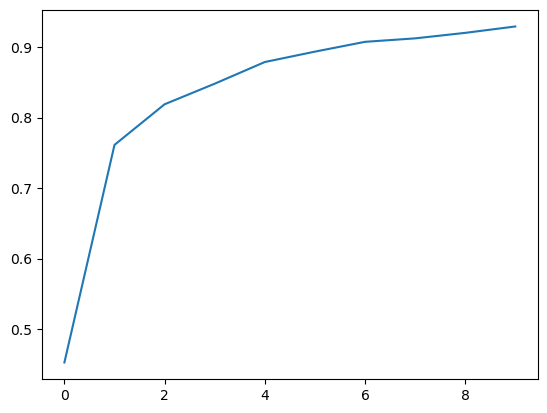

In [50]:
plt.plot(model_history.history["accuracy"])

In [51]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 2s 2s/step


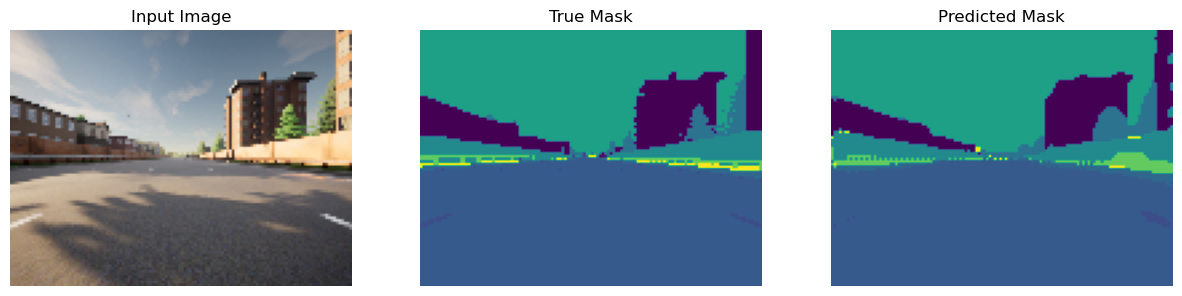

1/1 [==============================] - 1s 1s/step


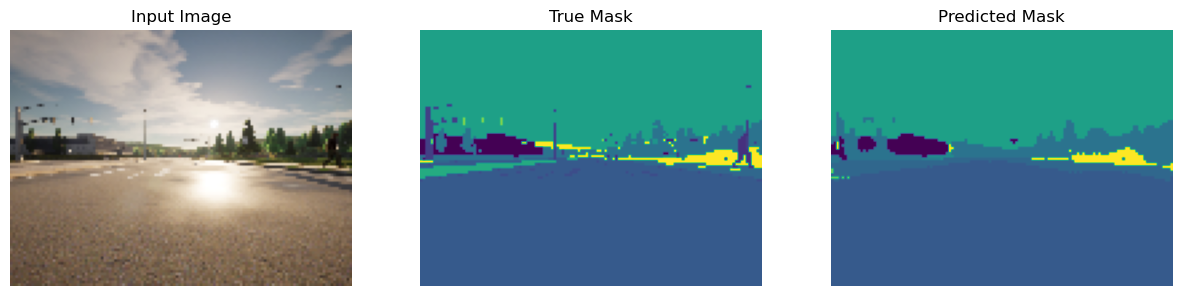

1/1 [==============================] - 1s 1s/step


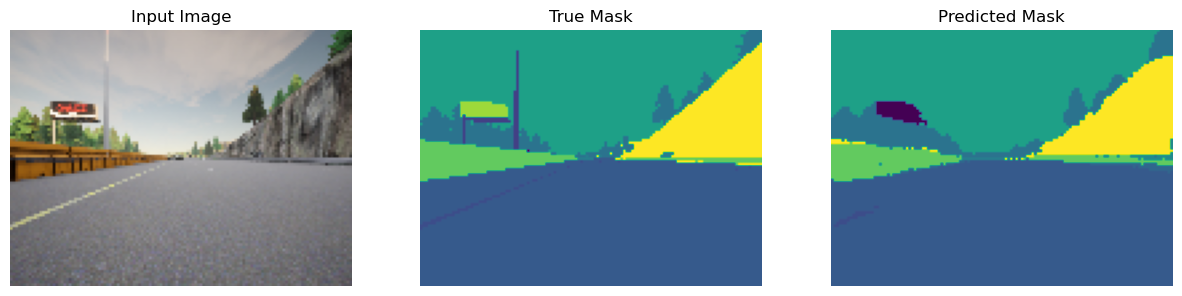

1/1 [==============================] - 1s 1s/step


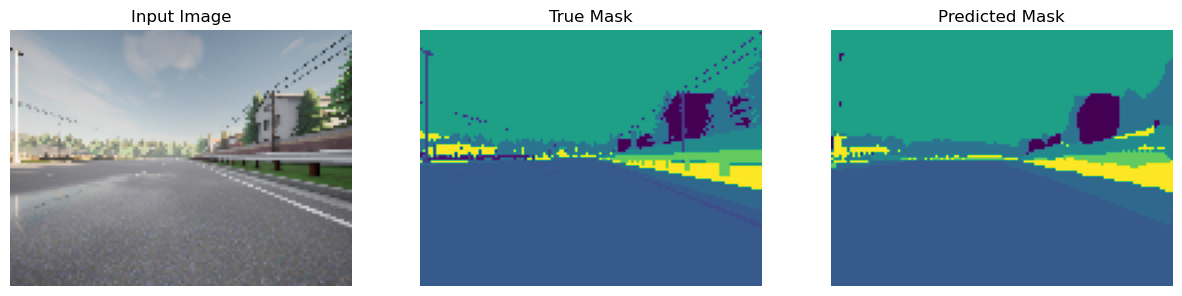

1/1 [==============================] - 1s 1s/step


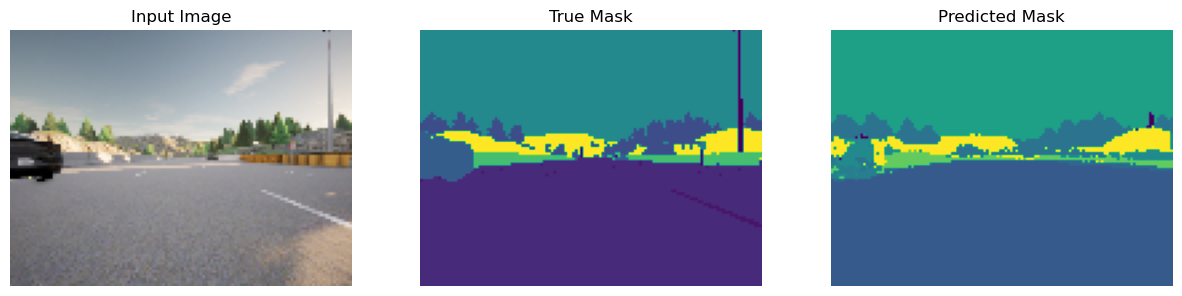

1/1 [==============================] - 1s 1s/step


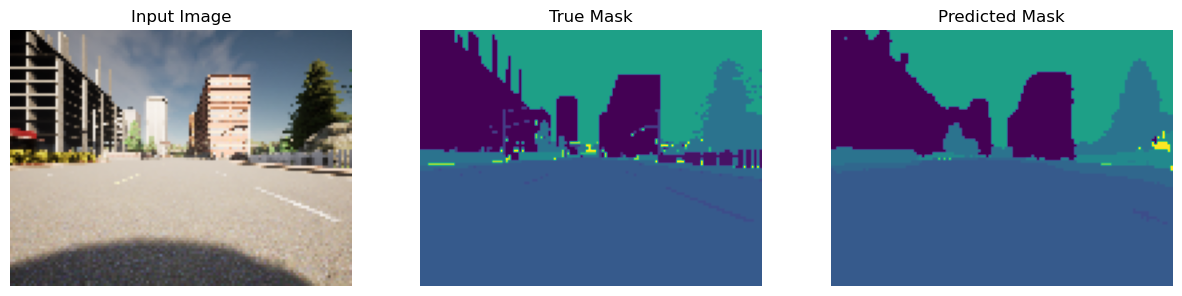

In [52]:
show_predictions(train_dataset, 6)

In [39]:

import pydot



tf.keras.utils.plot_model(unet)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
